<a href="https://colab.research.google.com/github/mcurcio5/OOTM-Option-Pricing-with-Power-Laws-and-News/blob/master/HawkesProcess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hawkes Processes for earnings
This notebook will determine how earnings report releases change the parameters of the Hawkes processes fitting the motion of different Technology stocks. 

I will build a two-variable (positive and negative stock movements) Hawkes process with exponential marks (distribution of price changes) and a power law kernel. 

Later, I will add a second kernel explaining changes in the point process due to preplanned corperate news releases, such as earnings.

I will use this model to value near-term OOTM options around corperate events via simulation.


NOTE: This code is currently very ugly. For cleaner code look at the other ipynb file :)

In [ ]:
# mount Google Drive to Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

FOLDERNAME = 'Colab/Projects/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

%cd drive/My\ Drive/$FOLDERNAME

In [ ]:
!pip install finnhub-python

In [3]:
import requests
import matplotlib as plt
import pandas as pd
import numpy as np
from datetime import timezone, datetime, timedelta
import finnhub
from scipy.optimize import minimize

First, I'm going to see what data is available in the FinnHub API.

Later, I will look at Hawkes processes

In [ ]:
df = pd.DataFrame(finnhub_client.company_basic_financials('AAPL', 'margin'))
df

,metric,metricType,symbol
freeOperatingCashFlow/revenue5Y,19.40911,margin,AAPL
freeOperatingCashFlow/revenueTTM,21.05369,margin,AAPL
grossMargin5Y,38.71825,margin,AAPL
grossMarginAnnual,37.81777,margin,AAPL
grossMarginTTM,38.18781,margin,AAPL
netProfitMargin5Y,21.89832,margin,AAPL
netProfitMarginAnnual,21.23809,margin,AAPL
netProfitMarginTTM,21.33376,margin,AAPL
operatingMargin5Y,27.18679,margin,AAPL
operatingMarginAnnual,24.57202,margin,AAPL


In [ ]:
d = finnhub_client.company_executive('AAPL')
df = pd.DataFrame(d['executive'])
df.head()

,age,compensation,currency,name,position,sex,since
0,69.0,557922.0,USD,Dr. Arthur Levinson,Independent Chairman of the Board,male,2011
1,59.0,11555466.0,USD,Mr. Timothy Cook,"Chief Executive Officer, Director",male,2011
2,56.0,25209637.0,USD,Mr. Luca Maestri,"Chief Financial Officer, Senior Vice President",male,2014
3,56.0,25207919.0,USD,Mr. Jeffrey Williams,Chief Operating Officer,male,2018
4,55.0,25231800.0,USD,Ms. Katherine Adams,"Senior Vice President, General Counsel, Secretary",female,2017


In [ ]:
print(finnhub_client.company_peers('AAPL'))

['AAPL', 'DELL', 'HPQ', '1337.HK', 'HPE', 'WDC', 'NTAP', 'PSTG', 'XRX', 'NCR']


In [ ]:
d = finnhub_client.financials_reported(symbol='AAPL')
df = pd.DataFrame(d['data'])

In [ ]:
finnhub_client.company_profile(symbol='AAPL')

In [ ]:
import time

d = finnhub_client.etfs_holdings('SPY')
df = pd.DataFrame(d['holdings'])
profiles = []
for symbol in df['symbol']:
  profiles.append(finnhub_client.company_profile(symbol=symbol))
  time.sleep(1)
  print("added:",symbol)

In [ ]:
df['gsector'] = [profiles[i]['gsector'] for i in range(len(profiles))]
df.head()

In [ ]:
df['profiles'] = profiles
df.head()

,percent,share,symbol,profiles
0,5.918711,43766308,AAPL,"{'address': '1 Apple Park Way', 'city': 'Cuper..."
1,5.815551,81420240,MSFT,"{'address': '1 Microsoft Way', 'city': 'Redmon..."
2,4.730508,4501968,AMZN,"{'address': '410 Terry Ave N', 'city': 'Seattl..."
3,2.180427,25837586,FB,"{'address': '1601 Willow Rd', 'city': 'Menlo P..."
4,1.710792,3224102,GOOGL,"{'address': '1600 Amphitheatre Pkwy', 'city': ..."


In [ ]:
# get data for S&P companies
d = finnhub_client.etfs_holdings('SPY')
df = pd.DataFrame(d['holdings'])
df2 = pd.DataFrame()
for i in range(len(profiles)):
  df2 = df2.append(pd.DataFrame(list([profiles[i].values()]), columns=list(profiles[i].keys())))
df2['symbol'] = df2['ticker']
df2 = df2.drop('ticker', axis=1)
df3 = df.merge(df2, on='symbol')

In [ ]:
#df3.to_csv('./SP500_info.csv')

In [5]:
df3 = pd.read_csv('./SP500_info.csv')
tech = df3.loc[df3['finnhubIndustry'] == 'Technology']

In [6]:
tech.head()

,Unnamed: 0,percent,share,symbol,address,city,country,currency,cusip,description,employeeTotal,exchange,finnhubIndustry,ggroup,gind,gsector,gsubind,ipo,isin,logo,marketCapitalization,naics,naicsNationalIndustry,naicsSector,naicsSubsector,name,phone,sedol,shareOutstanding,state,weburl
0,0,5.918711,43766308,AAPL,1 Apple Park Way,Cupertino,US,USD,037833100,"Apple, Inc. engages in the design, manufacture...",137000.0,NASDAQ NMS - GLOBAL MARKET,Technology,Technology Hardware & Equipment,"Technology Hardware, Storage & Peripherals",Information Technology,"Technology Hardware, Storage & Peripherals",1980-12-12,US0378331005,https://static.finnhub.io/logo/87cb30d8-80df-1...,1900306.0,Communications Equipment Manufacturing,Radio and Television Broadcasting and Wireless...,Manufacturing,Computer and Electronic Product Manufacturing,Apple Inc,1.408996e+10,2046251,4275.634000,CALIFORNIA,https://www.apple.com/
1,1,5.815551,81420240,MSFT,1 Microsoft Way,Redmond,US,USD,594918104,Microsoft Corp. engages in the development and...,144000.0,NASDAQ NMS - GLOBAL MARKET,Technology,Software & Services,Software,Information Technology,Systems Software,1986-03-13,US5949181045,NaN,1637262.0,Software Publishers,Software Publishers,Information,Publishing Industries (except Internet),Microsoft Corp,1.425883e+10,2588173,7567.652935,WASHINGTON,https://www.microsoft.com/en-us
6,6,1.228678,18128360,V,PO Box 8999,San Francisco,US,USD,92826C839,"Visa, Inc. engages in the provision of digital...",19500.0,"NEW YORK STOCK EXCHANGE, INC.",Technology,Software & Services,IT Services,Information Technology,Data Processing & Outsourced Services,2008-03-19,US92826C8394,https://static.finnhub.io/logo/96a1dba6-80ec-1...,417827.6,Activities Related to Credit Intermediation,"Financial Transactions Processing, Reserve, an...",Finance and Insurance,Credit Intermediation and Related Activities,Visa Inc,1.650432e+10,B2PZN04,2129.583923,CALIFORNIA,https://usa.visa.com/
11,11,0.994138,9481316,MA,2000 Purchase St,Purchase,US,USD,57636Q104,"Mastercard, Inc. operates as a technology comp...",18600.0,"NEW YORK STOCK EXCHANGE, INC.",Technology,Software & Services,IT Services,Information Technology,Data Processing & Outsourced Services,2006-05-25,US57636Q1040,NaN,330490.3,Activities Related to Credit Intermediation,"Financial Transactions Processing, Reserve, an...",Finance and Insurance,Credit Intermediation and Related Activities,Mastercard Inc,1.914249e+10,B121557,1001.060877,NEW YORK,https://investor.mastercard.com/investor-relat...
18,18,0.771999,5170264,ADBE,345 PARK AVE,San Jose,US,USD,00724F101,"Adobe, Inc. engages in the provision of digita...",22634.0,NASDAQ NMS - GLOBAL MARKET,Technology,Software & Services,Software,Information Technology,Application Software,1986-01-08,US00724F1012,https://static.finnhub.io/logo/9b4b19c2-80df-1...,215643.1,Software Publishers,Software Publishers,Information,Publishing Industries (except Internet),Adobe Inc,1.408537e+10,2008154,479.665239,CALIFORNIA,https://www.adobe.com/


In [ ]:
# get earnings dates for all tech stocks in S&P
earnings = []
for i in range(len(tech)):
  earnings.append(pd.DataFrame(finnhub_client.company_earnings(tech['symbol'].iloc[i])))
  #time.sleep(1)
  print(i)

In [ ]:
earnings_df = pd.DataFrame()
for i in len(earnings):
  earnings_df.
earnings[0]

,actual,estimate,period,symbol
0,2.55,2.3052,2020-03-31,AAPL
1,4.99,4.6410,2019-12-31,AAPL
2,3.03,2.8968,2019-09-30,AAPL
3,2.18,2.1420,2019-06-30,AAPL


In the following section, I will use a two-variable Hawkes Process with a Power Law Kernel and multivariate marks to model the movement of a single stock. I will use MLE methods to fit constraints on a Hawkes process at different time scales using a quasi-Newton optimization method to avoid calculating the inverse Hessian matrix. 

To confirm that the determined parameters fit the dataset, I will use parametric bootstrapping. 

Then, I will model how earnings reports changes the constraints of the Hawkes process across different industries in the S&P 500, focusing on technology stocks. 

Based on the relationship between earnings reports and Hawkes process constraints within different sectors, I will price near term OOTM options via simulation and techniques from Nassim Taleb's Technical Incerto.

The compensator and Log Likelihood for a single-variable and vector-value marks HP:

$\Lambda (t) := \int_{T_*}^{t} {\lambda (s) ds}$

$\log L = \int_{DxR^d} \log \lambda (t) N (dt \times dx) + \Sigma _{i=1}^d \int _{D\times R} \log f_i (x_i) N (dt \times dx) - \Lambda (T^*) + \int _{D \times R} \log c(F_1 (x_1),...,F_d(x_d))N(dt \times dx)$


I approximate a power law as the sum of exponential functions with power-law weights, to use a recurrence relation that reduces the log-likelihood calculation from $O(N^2)$ to $O(N)$.

$\phi (\tau | n, \epsilon, \tau _0) = \frac{n}{Z} \left( \Sigma _{i=0}^{M-1} \left( \frac{1}{\xi _i} \right) ^{1 + \epsilon} e^{-\tau / \xi_i} - S e ^{- \tau / \xi_{-1}} \right)$

for $\xi_i = \tau_0 m^i$ where $-1 \le i \lt M$

Parameter Z makes sure $\int_0^\infty \phi (\tau) d\tau = n$ and $S$ makes sure that $\phi (0) = 0$, as market participants can only react to events after more than 0 seconds.

In [ ]:
# my finhub API token
token = 'bsoarofrh5re01t4f9a0'
finnhub_client = finnhub.Client(api_key=token)

In [9]:
d = get_stock_data('AAPL')
d.head()

,c,h,l,o,s,t,v
0,323.83,323.87,323.76,323.78,ok,1582128300,10709
1,323.95,324.00,323.85,323.85,ok,1582128360,53238
2,323.95,324.06,323.90,323.94,ok,1582128420,22631
3,324.09,324.09,323.88,323.97,ok,1582128480,38680
4,324.18,324.19,324.08,324.08,ok,1582128540,25352


In [ ]:
def get_stock_data(ticker, resolution = 1):
  """ for stock symbol, get data
  @param ticker (str): ticker symbol
  @param resolution (int): time resolution of data
  @returns: Pandas DataFrame of stock data
  """
  # unix time stamp
  start = datetime(2020, 1, 1).replace(tzinfo=timezone.utc).timestamp()
  end = datetime(2020, 7, 1).replace(tzinfo=timezone.utc).timestamp()

  # Stock candles
  res = finnhub_client.stock_candles(ticker, resolution, start, end)
  return pd.DataFrame(res)

def get_df(df):
  """ Cleans data from API into form interpretable for Hawkes Process
  note: this function is really ugly rn but it works. will fix later
  @param df: output from get_stock_data() function
  @returns: pd DataFrame ready for analysis
  """
  df2 = pd.DataFrame()
  df2['diff'] = np.log(df['o']/df['o'].shift(1))
  df2['date'] = df['t'].apply(lambda x: datetime.fromtimestamp(x))
  # make the time stochastic - method from research paper
  df2['date'] = df2['date'].apply(lambda x: x - timedelta(seconds = np.random.uniform(0,60)))
  df2['v'] = df['v']
  df2['s'] = df['s']
  df2['dt'] = df2['date'] - df2['date'].shift(1)
  df2['dt'] = df2['dt'].apply(lambda x: x.total_seconds())
  len_before = df2.shape[0]
  df2 = df2.drop(df2.loc[df2['s'] != 'ok'].index, axis = 0)
  if (((len_before - df2.shape[0])/len_before) > .1):
    raise ValueError("Over 10% of dataframe returned NA")
  df2 = df2.drop(columns = 's')
  df2 = df2.drop(df2.loc[df2['dt'] > 10000].index, axis=0).iloc[1:]
  #df2 = df2.drop(df2.loc[df2['date'] != df2['date'].shift(1)].index, axis = 0)
  df2['dt'] = df2['dt']/100
  df2 = df2.reset_index(drop=True)

  # get only top 20% of movements
  q1 = df2['diff'].quantile(q=.1)
  q2 = df2['diff'].quantile(q=.9)
  # create mask for top 20% movement
  df2['event'] = 0
  df2.loc[(df2['diff'] < q1) | (df2['diff'] > q2), 'event'] = 1
  # calculate trading time between events (end of day is looped into next day)
  df2 = df2.reset_index(drop=True)
  l = df2.loc[df2['event']==1].index
  df2['dt_event'] = 0
  for i in range(1,len(l)):
    df2['dt_event'].iloc[l[i]] = np.sum(df2['dt'].iloc[l[i-1]:l[i]])
  df2 = df2.loc[df2['event']==1].reset_index(drop=True)
  df2['time_elapsed'] = 0
  prev = 0
  for i in range(1,df2.shape[0]):
    prev += df2['dt_event'].iloc[i]
    df2['time_elapsed'].iloc[i] = prev
  return df2

In [ ]:
df = get_df(get_stock_data('AAPL'))
df.head()

In [13]:
df.tail()

,diff,date,v,dt,event,dt_event,time_elapsed
9977,-0.001347,2020-06-30 19:09:02.254511,50739,0.263768,1,4.949274,35672.188095
9978,0.001099,2020-06-30 19:31:52.351355,91826,0.629987,1,13.334750,35685.522845
9979,0.001532,2020-06-30 19:54:12.104989,338873,0.479782,1,13.547741,35699.070586
9980,-0.001588,2020-06-30 19:57:26.191640,316326,0.697821,1,1.722827,35700.793413
9981,-0.001236,2020-06-30 23:00:29.961906,321,0.902955,1,109.632569,35810.425982


Hawke's MLE approach from https://arxiv.org/abs/1405.6047

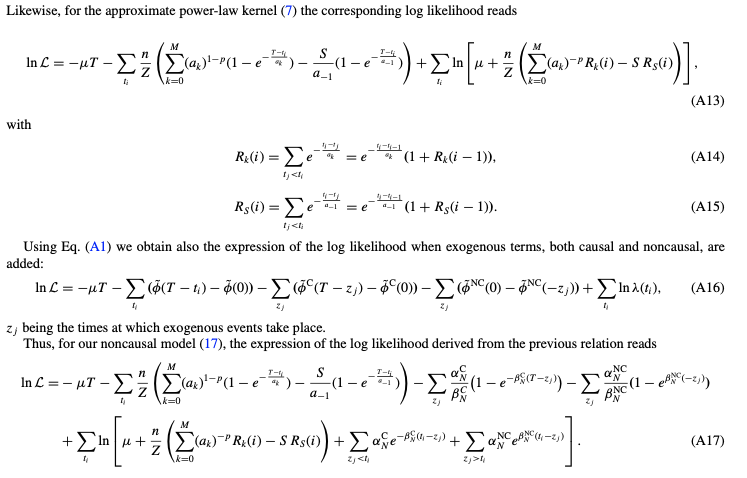

In [ ]:
# max log likelihood using power law kernel

def pl_likelihood(params):
  """ the power law kernel (sum of 15 exponentials) 
  @params (floats): n, p, t0 (see formulas)
  @returns (float): negative log likelihood for those parameters
  """
  n, p, t0 = params
  print("testing n = %s, p = %s, t0 = %s" % (n,p,t0))
  X = df # work around rn
  M = 15
  m = 5
  T = X['time_elapsed'].iloc[-1]
  N = X.shape[0] # number of events
  a_neg1 = t0*m**(-1)
  
  def A(k):
    return t0*m**k

  # calculate S so PL(0) = 0
  # make the first index the first event...
  S = np.sum([(A(k))**(-p) for k in range(M-1)])
  #print("S:",S)

  # calculate integral of phi power law 0 to inf to get Z
  phi_pl = 0

  for i in range(0,N):
    ti = X['time_elapsed'].iloc[i]
    term1 = np.sum([(A(k))**(-p)*np.exp(-ti/(A(k))) for k in range(M-1)])
    phi_pl = phi_pl + n*(term1 - S*np.exp(-ti/a_neg1))
  Z = phi_pl / n
  #print("Z =",Z)

  # calculate mu
  # big_lambda = 0
  # for i in range(1,N):
  #   # calculate the t values for list
  #   ti = X['time_elapsed'].iloc[i]
  #   local_sum = 0
  #   # could vectorize this loop
  #   for j in range(i):
  #     tj = ti - X['time_elapsed'].iloc[j]
  #     term1 = np.sum([(A(k))**(-p)*np.exp(-(tj)/(A(k))) for k in range(0,(M-1))])
  #     local_sum = local_sum + term1 - S*np.exp(-tj/a_neg1)
  #   big_lambda += n/Z*local_sum
  # mu = big_lambda*(1-n)
  mu = .1
  #print("mu =",mu)

  likelihood = -mu*T

  cache = dict([(1,0)])
  def RK(ind,k):
    if ind in cache:
      return cache[ind]
    ti = X['time_elapsed'].iloc[ind]
    ti_minus1 = X['time_elapsed'].iloc[ind-1]
    val = np.exp(-(ti - ti_minus1)/(t0*m**k))*(1+RK(ind-1,k))
    cache[ind] = val
    return val
  
  cache2 = dict([(1,0)])
  def R1(ind):
    if ind in cache2:
      return cache2[ind]
    ti = X['time_elapsed'].iloc[ind]
    ti_minus1 = X['time_elapsed'].iloc[ind-1]
    val = np.exp(-(ti - ti_minus1)/(t0*m**-1))*(1+R1(ind-1))
    cache2[ind] = val
    return val

  for i in range(1,N):
    ti = X['time_elapsed'].iloc[i]
    term1 = np.sum([(A(k))**(1-p)*(1-np.exp(-(T-ti)/(A(k)))) for k in range(0,M)])
    term2 = S/(a_neg1)*(1 - np.exp(-(T - ti)/a_neg1))
    logsum1 = np.sum([(A(k))**(-p)*RK(i,k) for k in range(0,M)])
    #print(R1(i))
    logterm1 = np.log(mu + n/Z*(logsum1 - S*R1(i)))
    likelihood = likelihood - n/Z*(term1 - term2) + logterm1
    #print(likelihood)

  print("Negative Likelihood:",-likelihood) # minimize negative likelihood!!
  return -likelihood # want to maximize likelihood with minimization function


In [ ]:
from scipy.optimize import SR1, Bounds

#set initial value guesses for n, p, t0. (.7,.9),(1.2,1.4),(1.2,3)
x0 = np.array([.7,1.25,1.5])
# set linear constraint
bounds = Bounds([0, 1.0, .6],[1.0, 1.5, 5])
res = minimize(pl_likelihood, x0, method='trust-constr',jac="2-point",hess=SR1(),
               options={'verbose':1}, bounds = bounds)

testing n = 0.7, p = 1.25, t0 = 1.5
Negative Likelihood: 16688.94049376014
testing n = 0.7000000149011611, p = 1.25, t0 = 1.5
Negative Likelihood: 16688.94038709305
testing n = 0.7, p = 1.2500000186264515, t0 = 1.5
Negative Likelihood: 16688.93990155452
testing n = 0.7, p = 1.25, t0 = 1.5000000223517418
Negative Likelihood: 16688.940759331996
testing n = 0.6953762060935103, p = 1.5452545351282438, t0 = 1.3091569143234465
Negative Likelihood: 6986.017015369705
testing n = 0.6953762209946714, p = 1.5452545351282438, t0 = 1.3091569143234465
Negative Likelihood: 6986.016718057339
testing n = 0.6953762060935103, p = 1.5452545581543307, t0 = 1.3091569143234465
Negative Likelihood: 6986.016674059532
testing n = 0.6953762060935103, p = 1.5452545351282438, t0 = 1.3091569338314046
Negative Likelihood: 6986.017458898897
testing n = 0.8689561040807787, p = 1.586102422470796, t0 = 0.9952762677763243
Negative Likelihood: -11534.706495687646
testing n = 0.8689561189819399, p = 1.586102422470796, t0 =

In [ ]:
print(res.x)

[0.9999991  1.49999903 0.60000022]
